# AMLO Exploratory Data Analysis

In [32]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Minmaxscaler
from sklearn.preprocessing import MinMaxScaler

# Local imports
from training_set import TrainingSet
from xgb_model import XGBoost

# For viz
import matplotlib.pyplot as plt
import seaborn as sns

#### CONSTANTS

In [30]:
PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/text_files/"
LABELED_PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/amlo_labeling.xlsx"
DATA_PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/"

### Pipeline

Create training set, along with its correspoding txt files

In [17]:
all_files = os.listdir(PATH)

training_set = TrainingSet(remove_stopwords=True)
training_set.create_training_set()

 39%|███▉      | 490/1246 [00:00<00:00, 4866.47it/s]

Conference 20181207 is not agressive
Conference 20190102 is not agressive
Conference 20190111 is not agressive
Conference 20190227 is not agressive
Conference 20200128 is not agressive
Conference 20210510 is not agressive


100%|██████████| 1246/1246 [00:00<00:00, 4723.02it/s]

Conference 20221125 is not agressive


In [18]:
# Specify the path to your training data folder
folder_path = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/training_data/"

param = {
    "max_depth": 8,
    "eta": 0.15,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}


xgb_model = XGBoost(
    folder_path=folder_path,
    dialogues_path=training_set.DIALOGUES_PATH,
    xgb_params=param,
)


xgb_model.create_regression_training_df()
xgb_model.create_unseen_df()

In [19]:
training_df = xgb_model.training_df
unseen_df = xgb_model.unseen_df

### Trying to implement a NNet model

In [20]:
def build_vocab(texts, tokenizer, min_freq=1):
    """
    Builds a vocabulary from the given texts based on frequency.

    Args:
    - texts (list of str): List of text samples.
    - tokenizer (callable): Function to tokenize text.
    - min_freq (int): Minimum frequency for a word to be included in the vocab.

    Returns:
    - vocab (dict): Mapping of word to unique index.
    """
    # Tokenize all texts and count word frequencies
    counter = Counter(token for text in texts for token in tokenizer(text))

    # Filter words by min_freq and assign unique indices
    vocab = {
        word: i + 2
        for i, (word, freq) in enumerate(counter.items())
        if freq >= min_freq
    }  # Start indexing from 2

    # Special tokens
    vocab["<pad>"] = 0  # Padding token
    vocab["<unk>"] = 1  # Unknown word token

    return vocab


# Example tokenizer function
def tokenizer(text):
    return text.split()

In [21]:
class AggressivityDataset(Dataset):
    def __init__(self, texts, vocab, scores=None):
        """
        texts: List of text data
        vocab: A dictionary mapping tokens to indices
        scores: List of aggressivity scores (for training data); None for unseen data
        """
        self.texts = [self.numericalize(text, vocab) for text in texts]
        self.scores = scores

    def numericalize(self, text, vocab):
        # Simple tokenization and numericalization based on the provided vocab
        tokenized = (
            text.lower().split()
        )  # Simple whitespace tokenization, adjust as needed
        return [
            vocab.get(token, 0) for token in tokenized
        ]  # 0 as the index for unknown words

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {"text": self.texts[idx]}
        if self.scores is not None:  # Handle cases where scores might not be available
            item["score"] = self.scores[idx]
        return item


def collate_fn(batch):
    text_sequences = [
        torch.tensor(item["text"], dtype=torch.long) for item in batch
    ]  # Ensure conversion to tensor
    # Check if 'score' key exists and handle accordingly
    scores = (
        torch.tensor([item["score"] for item in batch], dtype=torch.float)
        if "score" in batch[0]
        else None
    )

    text_sequences_padded = pad_sequence(
        text_sequences, batch_first=True, padding_value=0
    )

    return (
        (text_sequences_padded, scores) if scores is not None else text_sequences_padded
    )

In [22]:
# Build vocab from your training_df['text']
vocab = build_vocab(training_df["text"].tolist(), tokenizer)

training_dataset = AggressivityDataset(
    training_df["text"].tolist(), vocab, training_df["score"].tolist()
)


unseen_dataset = AggressivityDataset(unseen_df["text"].tolist(), vocab, scores=None)

batch_size = 32

In [23]:
train_loader = DataLoader(
    training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
unseen_loader = DataLoader(
    unseen_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

## Define Neural Network model

In [24]:
class NeuralRegressor(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(NeuralRegressor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(
            1
        )  # Average pooling
        output = self.fc(pooled)
        return output

In [48]:
def train_model(vocab, train_loader, num_epochs=100):
    """
    This function wraps the entire training process: data loading, model creation,
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = NeuralRegressor(vocab_size=len(vocab) + 1, embedding_dim=100).to(device)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)


    for epoch in range(num_epochs):


        model.train()


        for batch in train_loader:


            inputs, targets = (
                batch  # Here, batch directly unpacks into inputs and targets
            )


            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs).squeeze(1)

            loss = criterion(outputs, targets)

            loss.backward()

            optimizer.step()


        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

### Predict score

In [26]:
with torch.no_grad():
    predictions = []
    for inputs in unseen_loader:  # No targets here
        inputs = inputs.to(device)  # Ensure inputs are on the correct device
        outputs = model(inputs).squeeze(1)
        predictions.extend(outputs.cpu().numpy())

In [33]:
unseen_df["score"] = predictions

nnet_agressivity_scores = pd.concat([training_df, unseen_df], axis=0)

scaler = MinMaxScaler()
# Normalize the score
scores = np.array(nnet_agressivity_scores["score"]).reshape(-1, 1)
scaler.fit(scores)
nnet_agressivity_scores["score"] = scaler.transform(scores)
nnet_agressivity_scores.to_csv(f"{DATA_PATH}nnet_agressivity_scores.csv", index=False)

Text(0.5, 1.0, 'Distribution of Aggressivity Scores - Neural Net Model')

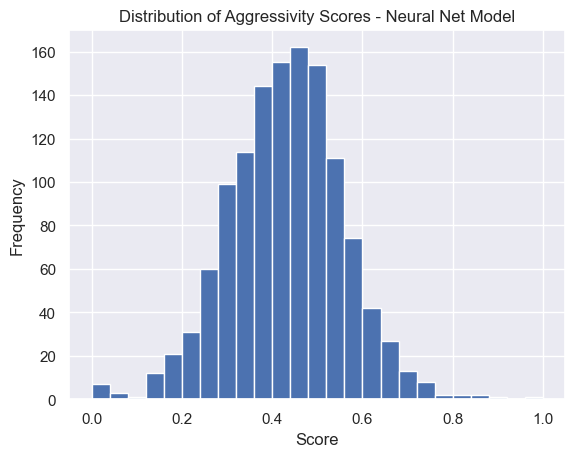

In [34]:
# Histogram of the scores
sns.set()
plt.hist(nnet_agressivity_scores["score"], bins=25)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Aggressivity Scores - Neural Net Model")

### Add this score to the complete dataset

In [43]:
complete_dataset_BDD = pd.read_csv(f"{DATA_PATH}complete_dataset_BDD.csv")

nnet_agressivity_scores.rename(columns={"score": "nnet_score"}, inplace=True)

In [47]:
complete_dataset_BDD = pd.merge(
    complete_dataset_BDD,
    nnet_agressivity_scores[["id", "nnet_score"]],
    on="id",
    how="left",
)

complete_dataset_BDD.to_csv(f"{DATA_PATH}complete_dataset_BDD.csv", index=False)